# `method` on zf

# running `method` on zf

## imports

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install scanpy -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.0/129.0 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 7.4 MB/s eta 0:00:00


In [4]:
import pandas as pd
import scanpy as sc
import numpy as np
import torch
import sys
from scipy.spatial.distance import cdist
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import sys
import importlib

In [24]:
filehandle_wdm = 'drive/Othercomputers/numac/GitHub/WDM/'
filehandle_save = 'drive/Othercomputers/numac/GitHub/celltypediscovery/_wdm_save_sc/'
filehandle_save_factors = 'drive/Othercomputers/numac/GitHub/celltypediscovery/_wdm_save_sc_factors/'
filehandle_zf = 'drive/MyDrive/DX/_data/zebrafish/cleaned_common_pca_sc/'

sys.path.insert(0, filehandle_wdm)
sys.path.insert(0, filehandle_save)
sys.path.insert(0, filehandle_zf)

import clustering
import util_LR
import util_zf
import FRLC_LRDist

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

## reload

In [6]:
importlib.reload(clustering)
importlib.reload(util_LR)
importlib.reload(util_zf)
importlib.reload(FRLC_LRDist)

<module 'FRLC_LRDist' from '/content/drive/Othercomputers/numac/GitHub/WDM/FRLC_LRDist.py'>

## device

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'On device: {device}')
dtype = torch.float64

On device: cuda


## make synthetic data

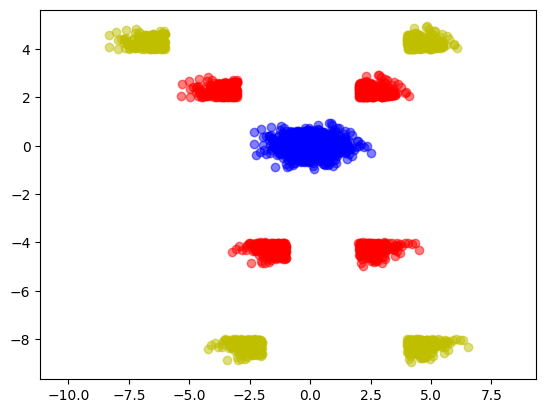

In [25]:
center_t1_A = np.array([0, 0])

center_t2_B = np.array([3, 1])
center_t2_C = np.array([-2, 1])
center_t3_D = np.array([4, 5])
center_t3_E = np.array([-3,5])

cov_t1_A = np.array([[6, 0], [0, 1]])
cov_t2_B = np.array([[2, 0], [0, 1]])
cov_t2_C = np.array([[2, 0], [0, 1]])
cov_t3_D = np.array([[2, 0], [0, 1]])
cov_t3_E = np.array([[2, 0], [0, 1]])

num_A = 1000
num_B = 75
num_C = 75
num_D = 100
num_E = 100

var = .1 # var of Gaussians used to make each cluster

t1_A = np.random.multivariate_normal(center_t1_A, var*cov_t1_A, size=num_A)
t2_B = np.random.multivariate_normal(center_t2_B, var*cov_t2_B, size=num_B)
t2_C = np.random.multivariate_normal(center_t2_C, var*cov_t2_C, size=num_C)
t3_D = np.random.multivariate_normal(center_t3_D, var*cov_t3_D, size=num_D)
t3_E = np.random.multivariate_normal(center_t3_E, var*cov_t3_E, size=num_E)

# make expression data at each timepoint
X1 = t1_A

def dy_dt(vars, t):
    tau = 0.0
    x, y = vars
    if y > 0 and x > tau:
        dxdt = 2 #y - x
        dydt = 2
    elif y > 0 and x < -tau:
        dxdt = -3 #y - x
        dydt = 2
    elif y < 0 and x > tau:
        dxdt = 2 #y - x
        dydt = -4
    elif y < 0 and x < tau:
        dxdt = -1 #y - x
        dydt = -4
    '''
    else:
        dxdt = 0 #y - x
        dydt = 5
    '''
    '''
    dxdt = y #y - x
    dydt = 2*x - 3*y #5 * x**2 / (4 + x**2) - y
    '''
    return [dxdt, dydt]

X2 = np.zeros(X1.shape)
X3 = np.zeros(X1.shape)

ts = np.array([0, 1, 2])
for i in range(X1.shape[0]):
    IC = X1[i,:]
    solution = np.array( odeint(dy_dt, [IC[0], IC[1]], ts) )
    X2[i,:] = solution[1,:]
    X3[i,:] = solution[2,:]

#X2 = np.concatenate((t2_B, t2_C))
#X3 = np.concatenate((t3_D, t3_E))

plt.scatter(X1[:,0], X1[:,1], c='b', alpha=0.5)
plt.scatter(X2[:,0], X2[:,1], c='r', alpha=0.5)
plt.scatter(X3[:,0], X3[:,1], c='y', alpha=0.5)
plt.axis('equal')
plt.show()

## move data to torch, make cost matrices, make dummy factors

In [30]:
X1 = torch.from_numpy(X1).type(torch.DoubleTensor).to(device)
X2 = torch.from_numpy(X2).type(torch.DoubleTensor).to(device)
X3 = torch.from_numpy(X3).type(torch.DoubleTensor).to(device)

C12 = torch.cdist(X1, X2).to(device)
C23 = torch.cdist(X2, X3).to(device)
c = torch.max(torch.tensor([torch.max(C12), torch.max(C23)]))
C12, C23 = C12/c, C23/c

A11 = torch.cdist(X1, X1).to(device)
A22 = torch.cdist(X2, X2).to(device)
A33 = torch.cdist(X3, X3).to(device)

Cs = [C12, C23]
As = [A11, A22, A33]

C_factors_sequence = [(C12, torch.eye(C12.shape[1]).type(torch.DoubleTensor).to(device)),
                      (C23, torch.eye(C23.shape[1]).type(torch.DoubleTensor).to(device))]
A_factors_sequence = [(A11, torch.eye(A11.shape[1]).type(torch.DoubleTensor).to(device)),
                      (A22, torch.eye(A22.shape[1]).type(torch.DoubleTensor).to(device)),
                      (A33, torch.eye(A33.shape[1]).type(torch.DoubleTensor).to(device))]

## set OT hyperparameters

In [31]:
gamma=40

tau_in_times_gamma = 2e-6

tau_out=1e5
tau_in=tau_in_times_gamma / gamma
alpha = 0.0
beta = 0.0

max_iter=100
min_iter=100

ranks = [(4,4),(4,4),(4,4)]

print(f"""
Data Processing and HM-OT Parameters:
-----------------------
Gamma: {gamma}
Tau (Out): {tau_out}
Tau (In): {tau_in}
Tau (In) x Gamma: {tau_in_times_gamma}
Alpha: {alpha}
Beta: {beta}
Max Iterations: {max_iter}
Min Iterations: {min_iter}
ranks: {ranks}
""")


Data Processing and HM-OT Parameters:
-----------------------
Gamma: 40
Tau (Out): 100000.0
Tau (In): 5e-08
Tau (In) x Gamma: 2e-06
Alpha: 0.0
Beta: 0.0
Max Iterations: 100
Min Iterations: 100
ranks: [(4, 4), (4, 4), (4, 4)]



## run `WDM`

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 0.9894233369559132, GW-cost: 0.10801828676486169, Total cost: 0.9894233369559132
Final Wasserstein cost: 0.5360417663033611, GW-cost: 0.10436660559294753, Total cost: 0.5360417663033611


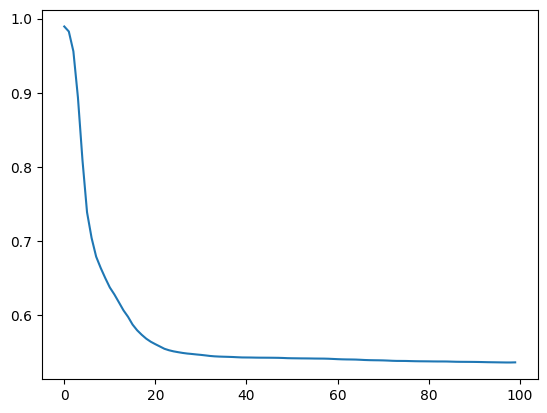

IndexError: list index out of range

In [34]:
%%time
import importlib
import WassersteinDiffMap
importlib.reload(WassersteinDiffMap)


WDM = WassersteinDiffMap.WassersteinDifferentiationMapping(ranks, tau_in = tau_in, tau_out=tau_out, \
                      gamma=gamma, max_iter=max_iter, min_iter=min_iter, device=device, dtype=torch.float64, \
                     printCost=True, returnFull=False, alpha=alpha, beta=beta, \
                      initialization='Full', init_args = None)

WDM.gamma_smoothing(A_factors_sequence, C_factors_sequence)

Qs_pred = [Q.cpu().numpy() for Q in WDM.Q_gammas]
Ts_pred = [T.cpu().numpy() for T in WDM.T_gammas]

In [21]:
Ss = spatial_list

node_labels1 = [None for Q in WDM.Q_gammas]

clustering.plot_clusters_from_QT(Ss, Qs_pred, Ts_pred, node_labels1, dotsize=10)
clustering.diffmap_from_QT(Qs_pred, Ts_pred, cell_type_labels=node_labels1, dsf=.3)

NameError: name 'Qs_pred' is not defined

## save

In [ ]:
for i,Q in enumerate(WDM.Q_gammas):
    np.save(filehandle_save + f'wdm_Q{i}.npy', Q.cpu().numpy())

for i,T in enumerate(WDM.T_gammas):
    np.save(filehandle_save + f'wdm_T{i}{i+1}.npy', T.cpu().numpy())

## ari, ami

In [ ]:
importlib.reload(util_zf)

In [ ]:
gt_types_list = clustering.max_likelihood_clustering(Qs_gt)
pred_types_list = clustering.max_likelihood_clustering(Qs_pred)

util_zf.compute_ARI_and_AMI(gt_types_list, pred_types_list)

In [ ]:
importlib.reload(util_zf)

In [ ]:
util_zf.silhouette(gt_types_list, pred_types_list, Xs, Ss)

In [ ]:
util_zf.cos_silhouette(gt_types_list, pred_types_list, Xs, Ss)

## freezing $Q$s with annotations, running `WDM`

In [ ]:
%%time
Q_annot = Qs_gt_tensor

importlib.reload(WassersteinDiffMap)

WDM2 = WassersteinDiffMap.WassersteinDifferentiationMapping(ranks, tau_in = tau_in, tau_out=tau_out, \
                      gamma=gamma, max_iter=100, min_iter=100, device=device, dtype=torch.float64, \
                     printCost=True, returnFull=False, alpha=alpha, beta=beta, \
                      initialization='Full', init_args=None)

WDM2.impute_annotated_transitions(C_factors_sequence, A_factors_sequence, Q_annot)
T_gammas = WDM2.T_gammas

In [ ]:
for i,Q in enumerate(WDM2.Q_gammas):
    np.save(filehandle_save + f'ann_Q{i}.npy', Q.cpu().numpy())

for i,T in enumerate(WDM2.T_gammas):
    np.save(filehandle_save + f'ann_T{i}{i+1}.npy', T.cpu().numpy())

# Analysis part 1: entropy of transitions

In [ ]:
Ts_ann = T_gammas
Ts_pred = Ts_pred

## entropy functions

In [ ]:
importlib.reload(util_zf)

In [ ]:
util_zf.compare_T_entropies(Ts_ann, Ts_pred)
print('\n')
util_zf.compare_T_col_entropies(Ts_ann, Ts_pred)

In [ ]:
importlib.reload(util_zf)

In [ ]:
for i, (T_ann, T_pred) in enumerate(zip(Ts_ann, Ts_pred)):
    T_ann = T_ann.cpu().numpy()
    util_zf.plot_collision_profiles(T_ann, T_pred, title=f'Convergence profiles at slice {i+2}')

In [ ]:
clustering.diffmap_from_QT(Qs_gt, Ts_ann, cell_type_labels=ct_labels, dsf=.3)

## what about arg-secondmax? Does this have biological signal?

In [ ]:
labels_2nd = []

for Q in Qs_pred:
    # Get the indices of the sorted entries for each row
    sorted_indices = np.argsort(Q, axis=1)

    # Extract the second-to-last index (the second largest) from the sorted indices
    second_largest_indices = sorted_indices[:, -2]
    labels_2nd += [second_largest_indices]

In [ ]:
threshold = 0.1  # Example threshold as a percentage of the largest value

labels_consensus = []

for Q in Qs_pred:
    argmax_labels = np.argmax(Q, axis=1)
    sorted_indices = np.argsort(Q, axis=1)
    second_argmax_labels = sorted_indices[:, -2]

    # Get the largest and second largest values from Q
    largest_values = np.max(Q, axis=1)
    second_largest_values = Q[np.arange(Q.shape[0]), second_argmax_labels]

    # Apply the threshold to choose between argmax and second argmax
    consensus_labels = np.where((largest_values - second_largest_values) / largest_values < threshold,
                                second_argmax_labels, argmax_labels)

    # Convert consensus_labels (NumPy array) to a regular Python list of ints
    labels = consensus_labels.tolist()  # Convert the array to a list
    labels = [int(label) for label in labels]  # Ensure all elements are ints
    labels = np.array(labels)
    labels_consensus.append(labels)  # Use append to add the new list of labels

# Now labels_consensus is a list of lists, suitable for plotting
clustering.plot_clustering_list(Ss, labels_consensus, dotsize=10)

In [ ]:
util_zf.compute_ARI_and_AMI(gt_types_list, labels_consensus)

In [ ]:
from scipy.special import softmax

def sample_random_labeling(Q, T=1.0, epsilon=1e-12):
    # Step 1: Normalize Q row-wise to make it row-stochastic
    row_sums = Q.sum(axis=1, keepdims=True)
    P = Q / row_sums

    # Handle division by zero in case row sums are zero
    P = np.nan_to_num(P)

    # Step 2: Take the logarithm of each element (add epsilon to avoid log(0))
    L = np.log(P + epsilon)

    # Step 3: Apply the built-in softmax function with temperature scaling
    # Adjust the input by dividing by the temperature T
    S = softmax(L / T, axis=1)

    # Step 4: Sample a label for each row based on the probabilities in S
    num_rows, num_cols = S.shape
    random_labels = np.array([
        np.random.choice(num_cols, p=S[i])
        for i in range(num_rows)
    ])

    return random_labels

In [ ]:
from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.metrics import adjusted_rand_score as ari

def get_ARI_and_AMI(gt_types_list, pred_types_list, x_percent=5):
    #print(f"ARI and AMI of predictions (filtered excludes ground truth clusters smaller than {x_percent}% of the data)\n")
    aris = []
    amis = []
    for i, (gt_types, pred_types) in enumerate(zip(gt_types_list, pred_types_list)):
        raw_ari = ari(gt_types, pred_types)
        raw_ami = ami(gt_types, pred_types)

        gt_labels = np.array(gt_types)
        pred_labels = np.array(pred_types)
        total_points = len(gt_labels)

        # Compute counts of ground truth clusters
        unique_labels, counts = np.unique(gt_labels, return_counts=True)
        percentages = counts / total_points * 100

        # Identify clusters to keep (clusters with size >= x%)
        clusters_to_keep = unique_labels[percentages >= x_percent]

        # Create a mask to keep only data points in clusters_to_keep
        mask = np.isin(gt_labels, clusters_to_keep)

        # Apply mask to both gt_labels and pred_labels
        gt_labels_filtered = gt_labels[mask]
        pred_labels_filtered = pred_labels[mask]

        # Compute ARI and AMI on the filtered labels
        x_ari = ari(gt_labels_filtered, pred_labels_filtered)
        x_ami = ami(gt_labels_filtered, pred_labels_filtered)

        aris += [x_ari]
        amis += [x_ami]

    return aris, amis

        #print(f'ARI for {i}th slice is {raw_ari:.3f} (filtered: {x_ari:.3f}) \t')
        #print(f'AMI for {i}th slice is {raw_ami:.3f} (filtered: {x_ami:.3f})')
        #print('\n')

In [ ]:
N_samples = 50

n_timepoints = len(Qs_pred)

scores = np.zeros((N_samples, n_timepoints, 2))


#for i in range(N_samples):


'''
for i in range(N_samples):

    labels_sampled = []

    for t, Q in enumerate(Qs_pred):
        random_labels = sample_random_labeling(Q, T=1e-3)
        labels_sampled.append(random_labels)  # Use append to add the new list of labels

    aris, amis = get_ARI_and_AMI(gt_types_list, labels_sampled)
    aris_inner_np = [ np.array(ari) for ari in aris ]
    amis_inner_np = [ np.array(ami) for ami in amis ]

    aris_np = np.array(aris_inner_np)
    amis_np = np.array(amis_inner_np)

    scores[i, :, 0] = aris_np
    scores[i, :, 1] = amis_np
''';

In [ ]:
print(np.mean(scores[:,:,0], axis=0))

In [ ]:
print(np.max(scores[:,:,0], axis=0))

# Analysis part 2: DE analysis

## load output of `WDM`

In [ ]:
wdm_Qs = []
wdm_Ts = []


wdm_Q0 = np.load(filehandle_save + 'wdm_Q0.npy')
wdm_Q1 = np.load(filehandle_save + 'wdm_Q1.npy')
wdm_Q2 = np.load(filehandle_save + 'wdm_Q2.npy')

wdm_T0 = np.load(filehandle_save + 'wdm_T0.npy')
wdm_T1 = np.load(filehandle_save + 'wdm_T1.npy')

ann_Q0 = np.load(filehandle_save+ 'ann_Q0.npy')

ann_Q1 = np.load(filehandle_save + 'ann_Q1.npy')
ann_Q1_imp = np.load(filehandle_save + 'ann_Q1_imp.npy')

ann_Q2 = np.load(filehandle_save + 'ann_Q2.npy')

ann_T0_imp = np.load(filehandle_save + 'ann_T0_imp.npy')
ann_T1_imp = np.load(filehandle_save + 'ann_T1_imp.npy')

ann_T0 = np.load(filehandle_save + 'ann_T0.npy')
ann_T1 = np.load(filehandle_save + 'ann_T1.npy')

### lists of these for the three cases

Qs_ann = [ann_Q0, ann_Q1, ann_Q2]
Ts_ann = [ann_T0, ann_T1]

Qs_ann_imp = [ann_Q0, ann_Q1_imp, ann_Q2]
Ts_ann_imp = [ann_T0_imp, ann_T1_imp]

Qs_wdm = [wdm_Q0, wdm_Q1, wdm_Q2]
Ts_wdm = [wdm_T0, wdm_T1]

## set ranks, set `i` = first timepoint of three: `i`, `i+1`, `i+2`

In [ ]:
ranks = [(3,7),(7,7),(7,11),(11,14),(14,19)]

i=2

r1, r2 = ranks[i]
r2, r3 = ranks[i+1]

## load features and spatial coords specific to the triple

In [ ]:
s0_name = zf_names[i]
s1_name = zf_names[i+1]
s2_name = zf_names[i+2]

filehandle_pair1 = filehandle_zf + 'pair' + str(i) + '/'
filehandle_pair2 = filehandle_zf + 'pair' + str(i+1) + '/'

X0 = np.load(filehandle_pair1 + s0_name + '_feature.npy')
X1 = np.load(filehandle_pair1 + s1_name + '_feature.npy')
X2 = np.load(filehandle_pair2 + s2_name + '_feature.npy')

S0 = spatial_list[i]
S1 = spatial_list[i+1]
S2 = spatial_list[i+2]

Ss = [S0, S1, S2]

## load labels

In [ ]:
filehandle_ctd = 'drive/Othercomputers/numac/GitHub/celltypediscovery/'

slice0_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice0_types.npy'))
slice1_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice1_types.npy'))
slice2_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice2_types.npy'))
slice3_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice3_types.npy'))
slice4_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice4_types.npy'))
slice5_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice5_types.npy'))

ct_labels = [ list(set(slice0_types)),
               list(set(slice1_types)),
                list(set(slice2_types)),
                list(set(slice3_types)),
                list(set(slice4_types)),
                list(set(slice5_types))]

target_value = 'Otic Vesicle'
# Find indices where the elements match the target value
indices = [index for index, value in enumerate(slice5_types) if value == 'Otic Vesicle']

print(f"Indices of '{target_value}' in the list: {indices}")

Indices of 'Otic Vesicle' in the list: [5041]


## case 1: `ml` clustering,  annotations

In [ ]:
type(slice5_types)

list

In [ ]:
importlib.reload(clustering)


clustering.both_from_QT(Ss=Ss,
                        Qs=Qs_ann,
                        Ts=Ts_ann,
                        cell_type_labels=cell_type_labels_case_1,
                        clustering_type='ml')

## case 2: `ml` clustering, annotations at $t_1, t_3$

In [ ]:
importlib.reload(clustering)


clustering.both_from_QT(Ss=Ss,
                        Qs=Qs_ann_imp,
                        Ts=Ts_ann_imp,
                        cell_type_labels=cell_type_labels_case_2,
                        clustering_type='ml')

## case 3: fully unsupervised

In [ ]:
importlib.reload(clustering)


clustering.both_from_QT(Ss=Ss,
                        Qs=Qs_wdm,
                        Ts=Ts_wdm,
                        cell_type_labels=cell_type_labels_case_3,
                        clustering_type='ml')

## focus on case 3, what does differential expression reveal about how these clusters compare to the annotations?

In [ ]:
pred_clustering_list = clustering.max_likelihood_clustering(Qs_wdm)
gt_clustering_list = clustering.max_likelihood_clustering(Qs_gt[2:5])

In [ ]:
pred_clustering_0 = pred_clustering_list[0]
pred_clustering_1 = pred_clustering_list[1]
pred_clustering_2 = pred_clustering_list[2]

## differential expression at 10hpf:

In [ ]:
_adata0 = adatas[2].copy()

_adata0.obs['diff_map_cluster'] = pred_clustering_0
_adata0.obs['diff_map_cluster'] = _adata0.obs['diff_map_cluster'].astype('category')
sc.pp.normalize_total(_adata0)
sc.pp.log1p(_adata0)

# Differential gene expression analysis
sc.tl.rank_genes_groups(_adata0, groupby='diff_map_cluster', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(_adata0, n_genes=10, sharey=False, key = "t-test")

# Bin-annotation
sc.tl.rank_genes_groups(_adata0, groupby='bin_annotation', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(_adata0, n_genes=10, sharey=False, key = "t-test")


## most interesting predicted clusters at 10hpf

## differential expression at 12hpf:

In [ ]:
_adata1 = adatas[3].copy()

_adata1.obs['diff_map_cluster'] = pred_clustering_1
_adata1.obs['diff_map_cluster'] = _adata1.obs['diff_map_cluster'].astype('category')
sc.pp.normalize_total(_adata1)
sc.pp.log1p(_adata1)

# Differential gene expression analysis
sc.tl.rank_genes_groups(_adata1, groupby='diff_map_cluster', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(_adata1, n_genes=10, sharey=False, key = "t-test")

# Bin-annotation
sc.tl.rank_genes_groups(_adata1, groupby='bin_annotation', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(_adata1, n_genes=10, sharey=False, key = "t-test")


## most interesting predicted clusters at 12hpf

## differential expression at 18hpf:

In [ ]:
_adata2 = adatas[4].copy()

_adata2.obs['diff_map_cluster'] = pred_clustering_2
_adata2.obs['diff_map_cluster'] = _adata2.obs['diff_map_cluster'].astype('category')
sc.pp.normalize_total(_adata2)
sc.pp.log1p(_adata2)

# Differential gene expression analysis
sc.tl.rank_genes_groups(_adata2, groupby='diff_map_cluster', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(_adata2, n_genes=10, sharey=False, key = "t-test")

# Bin-annotation
sc.tl.rank_genes_groups(_adata2, groupby='bin_annotation', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(_adata2, n_genes=10, sharey=False, key = "t-test")


## most interesting predicted clusters at 18hpf